# Edit domain_cfg.nc and mesh_mask.nc to fill lakes and problematic ice shelves

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import cartopy.crs as ccrs

In [2]:
home ='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/'

# domcfg_orig   = xr.open_dataset(f'{home}domain_cfg-nico-test.nc')
# meshmask_orig = xr.open_dataset(f'{home}mesh_mask-nico-test.nc')

In [3]:
def fill_lakes(array, dim='2D'):

    if dim=='2D':
        array[0, 186, slice(128,135)] = 0
        array[0, slice(447,453), slice(848,850)] = 0
        array[0, slice(441,446), slice(848,853)] = 0
        array[0, slice(426,438), slice(856,870)] = 0
        array[0, slice(424,431), slice(863,872)] = 0
        array[0, 318, slice(1350,1352)] = 0
    elif dim=='3D':
        array[0, :, 186, slice(128,135)] = 0
        array[0, :, slice(447,453), slice(848,850)]   = 0
        array[0, :, slice(441,446), slice(848,853)]   = 0
        array[0, :, slice(426,438), slice(856,870)]   = 0
        array[0, :, slice(424,431), slice(863,872)]   = 0
        array[0, :, 318           , slice(1350,1352)] = 0
    else:
        raise Exception('Only set up for dimension 2D or 3D')

    return array

In [4]:
def fill_problem_iceshelf(array, dim='2D'):
    # make problem iceshelf land...
    if dim=='2D':
        array[0, 309, 1327] = 0
        array[0, 219, 706] = 0
        array[0, 220, 706] = 0
    elif dim=='3D':
        array[0, :, 309, 1327] = 0
        array[0, :, 219, 706] = 0
        array[0, :, 220, 706] = 0
    else:
        raise Exception('Only set up for dimension 2D or 3D')

    return array

In [ ]:
# ---- Domain config file ------------
domcfg_new   = domcfg_orig.copy()
for var in ['bottom_level', 'bathy_metry', 'isf_draft', 'top_level']:
    new_array       = fill_lakes(domcfg_new[var].values, dim='2D')
    new_array       = fill_problem_iceshelf(new_array, dim='2D')
    domcfg_new[var] = (('time_counter', 'y', 'x'), new_array)

domcfg_new.to_netcdf(f'{home}domain_cfg-nico-test-method.nc', unlimited_dims=['time_counter'])

# ---- Mesh mask file ------------
meshmask_new = meshmask_orig.copy()
for var in ['bathy_metry', 'mbathy', 'misf', 'mhw', 'hw', 'tmaskutil', 'umaskutil', 'vmaskutil']:
    new_array         = fill_lakes(meshmask_new[var].values, dim='2D')
    new_array         = fill_problem_iceshelf(new_array, dim='2D')
    meshmask_new[var] = (('time_counter', 'y', 'x'), new_array)

for var in ['tmask', 'umask', 'vmask', 'fmask']:
    new_array         = fill_lakes(meshmask_new[var].values, dim='3D')
    new_array         = fill_problem_iceshelf(new_array, dim='3D')
    meshmask_new[var] = (('time_counter', 'nav_lev', 'y', 'x'), new_array)

meshmask_new.to_netcdf(f'{home}mesh_mask-nico-test-method.nc', unlimited_dims=['time_counter'])

### Make these changes in the original bathymetry files, so that the NEMO DOMAINcfg tool produces the same results

In [5]:
bathy_orig = xr.open_dataset(f'{home}bathy_meter_eORCA025_BedMachine3_IBCSO_AIS-20231025.nc')

In [30]:
# ---- Domain config file ------------
bathy_new   = bathy_orig.copy()
for var in ['Bathymetry', 'Bathymetry_isf', 'isf_draft']:
    new_array       = fill_lakes(bathy_new[var].values.reshape((1, bathy_new.y.size, bathy_new.x.size)), dim='2D')
    new_array       = fill_problem_iceshelf(new_array, dim='2D')
    bathy_new[var] = (('y', 'x'), new_array[0,:,:])

bathy_new.to_netcdf(f'{home}bathy_meter_eORCA025_BedMachine3_IBCSO_AIS-20250715.nc', unlimited_dims=['time_counter'])

(0.0, 460.0)

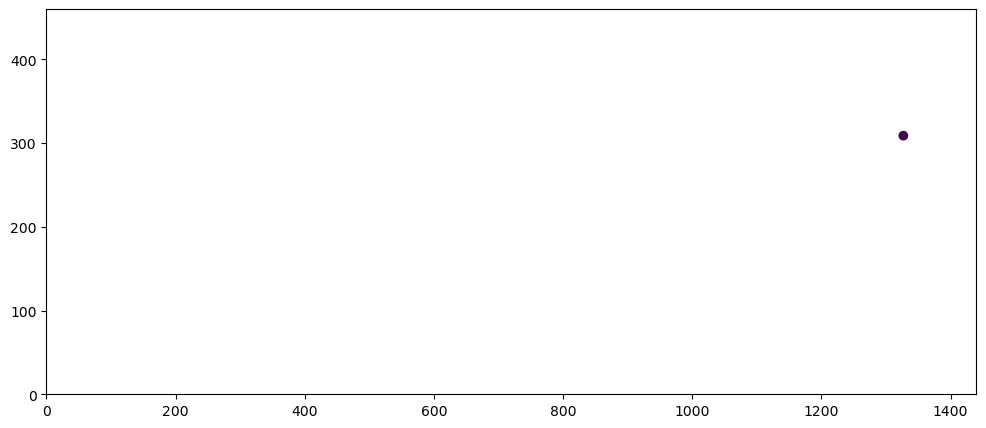

In [29]:
var='isf_draft' # Bathymetry, Bathymetry_isf, isf_draft
diff    = (bathy_new[var] - bathy_orig[var])
xx, yy  = np.meshgrid(bathy_new.x, bathy_new.y)

fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.scatter(xx, yy, c=diff.where(diff!=0))
ax.set_xlim(0,1440)
ax.set_ylim(0,460)

In [42]:
# check whether the resulting domcfg is identical to the other one and runs as it should
old_domcfg = xr.open_dataset(f'{home}domain_cfg-20250217.nc').squeeze()
new_domcfg = xr.open_dataset(f'{home}domain_cfg-20250715.nc').squeeze()

In [46]:
new_domcfg.bathy_metry.squeeze().equals(old_domcfg.bathy_metry.squeeze()) #.plot(figsize=(12,5))
var_uneq = []
for var in list(old_domcfg.keys()):
    if new_domcfg[var].equals(old_domcfg[var]):
        continue
    else:
        print(f'{var} is not identical')
        var_uneq.append(var)

e3t_0 is not identical
e3u_0 is not identical
e3v_0 is not identical
e3f_0 is not identical
e3w_0 is not identical
e3uw_0 is not identical
e3vw_0 is not identical
top_level is not identical
isf_draft is not identical


In [60]:
def plot_change(varx, vary, vardiff):
    xx, yy  = np.meshgrid(varx, vary)
    
    fig, ax = plt.subplots(1,1, figsize=(12,5))
    ax.scatter(xx, yy, c=vardiff.where(vardiff!=0))
    ax.set_xlim(0,1440)
    ax.set_ylim(0,453)
    return fig, ax

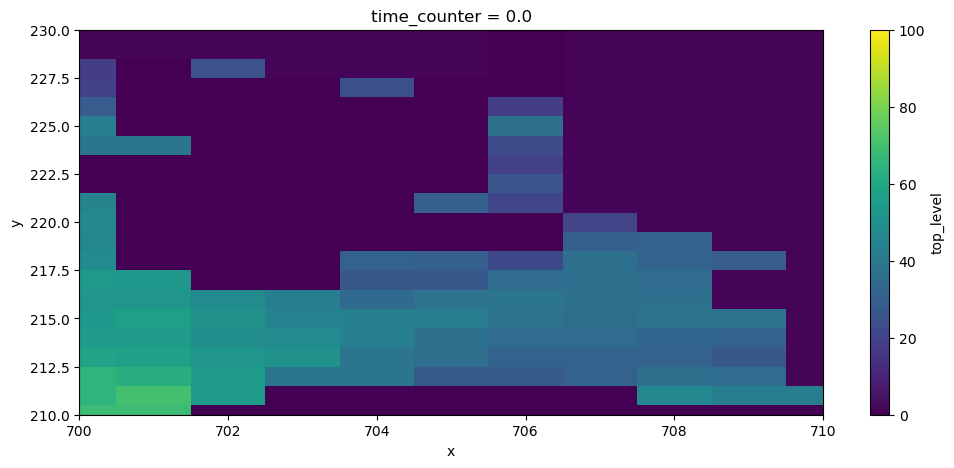

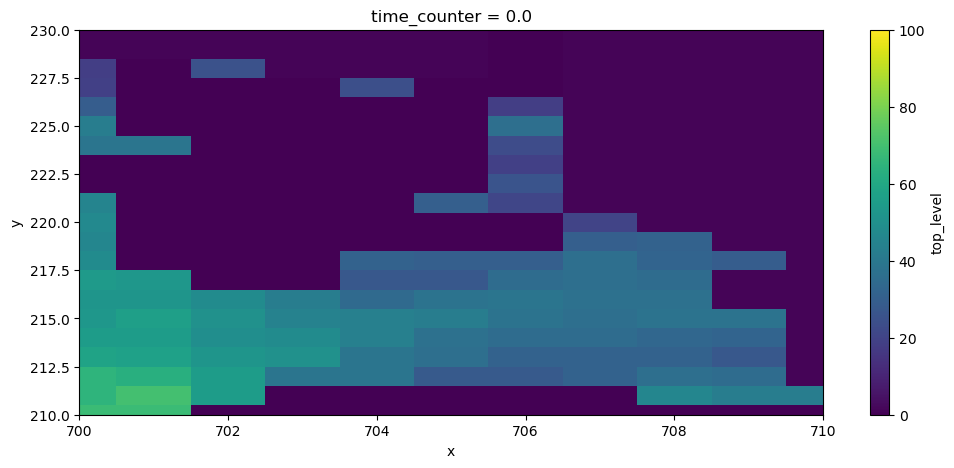

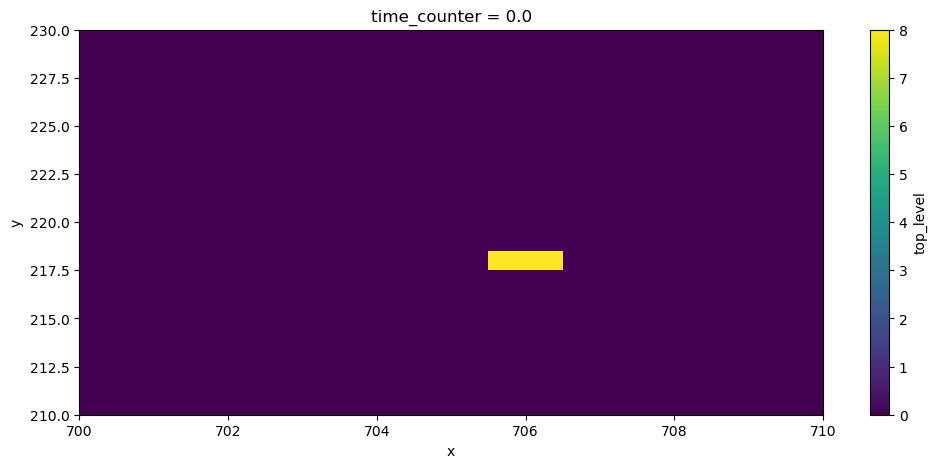

In [65]:
(old_domcfg['top_level']).plot(figsize=(12,5), xlim=(700,710), ylim=(210,230))
(new_domcfg['top_level']).plot(figsize=(12,5), xlim=(700,710), ylim=(210,230))
(new_domcfg['top_level'] - old_domcfg['top_level']).plot(figsize=(12,5), xlim=(700,710), ylim=(210,230))

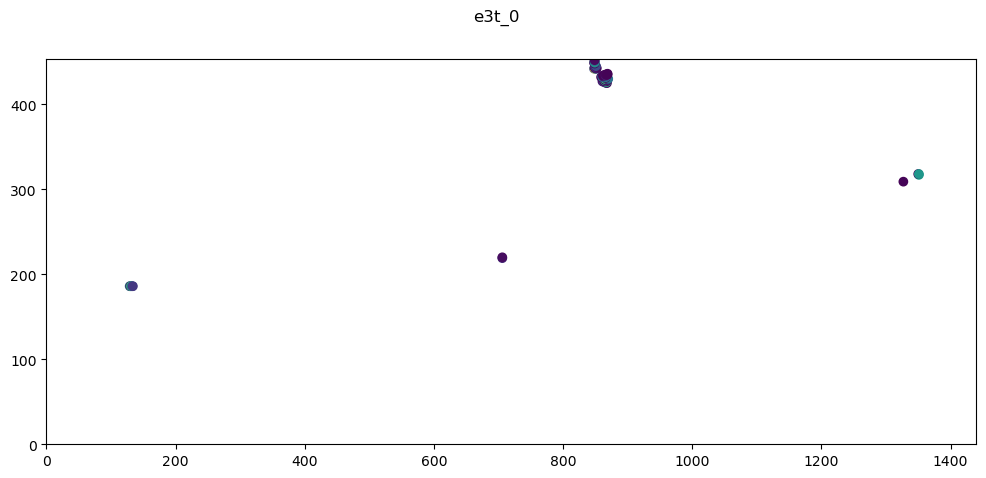

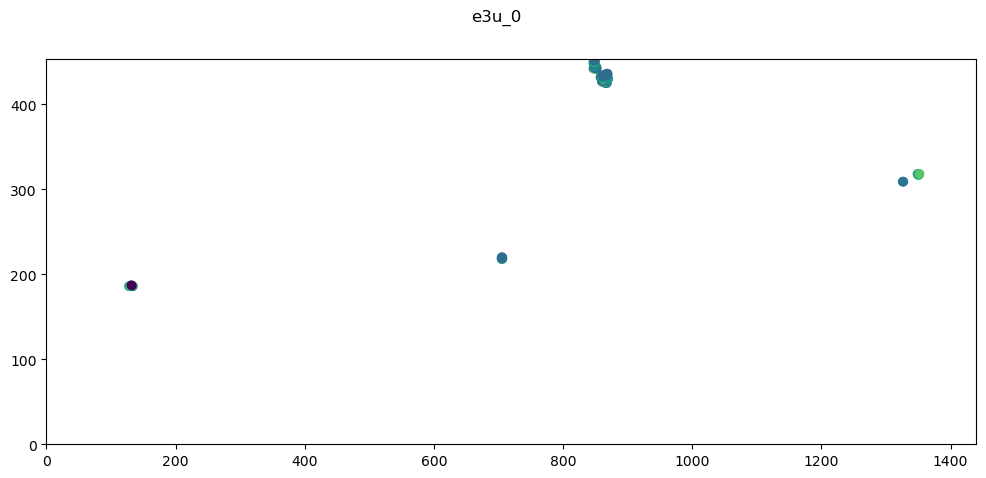

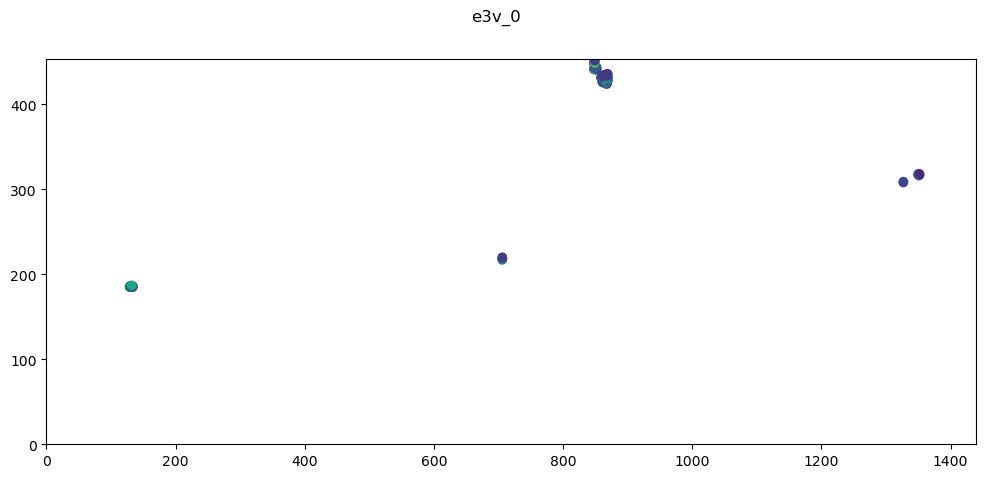

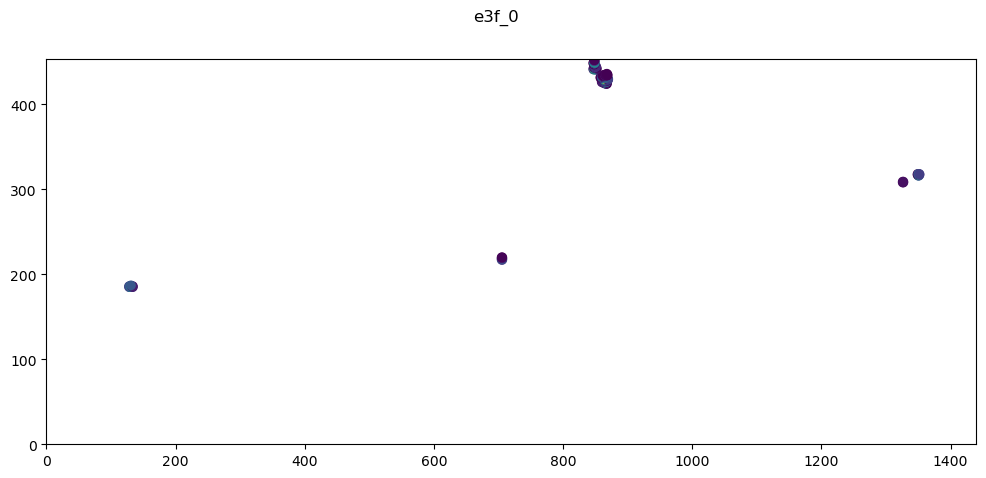

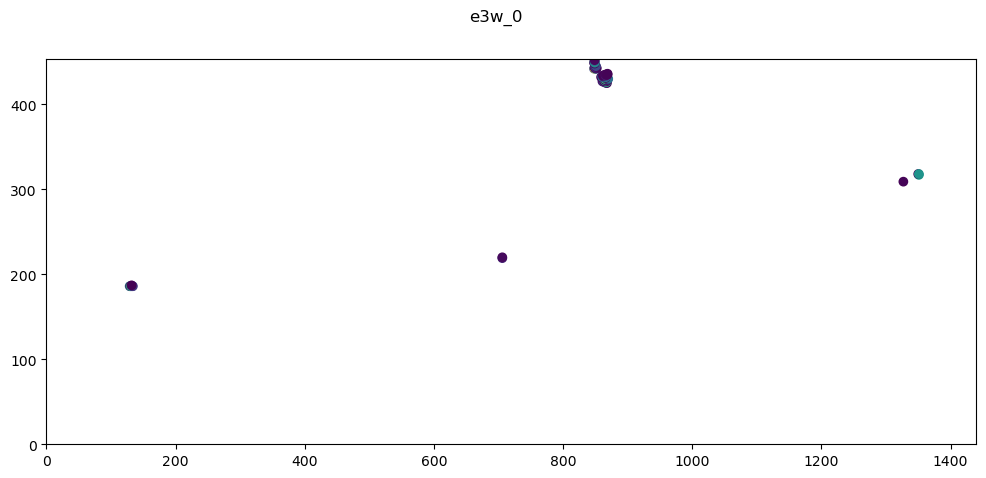

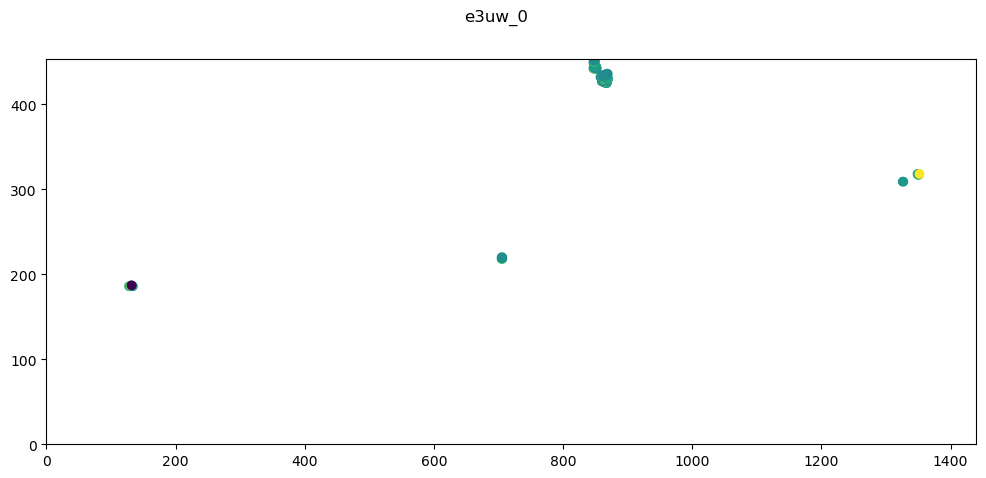

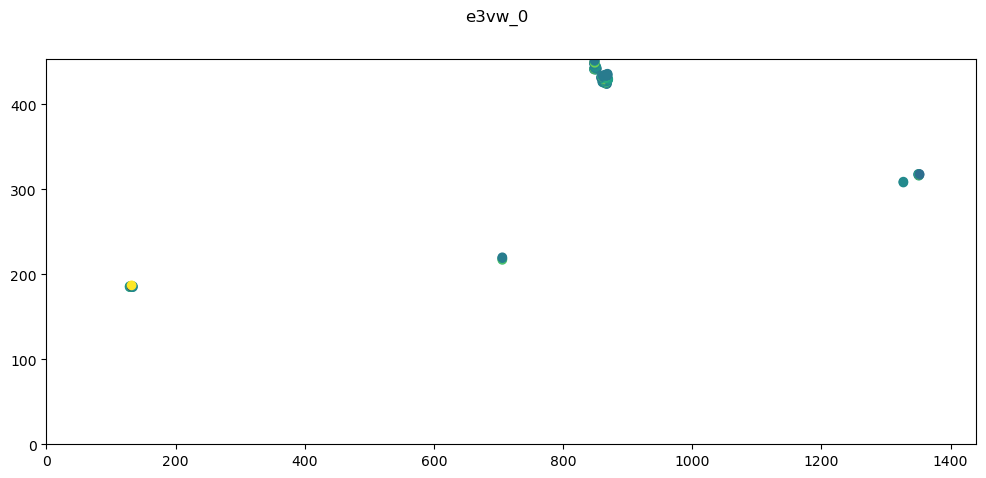

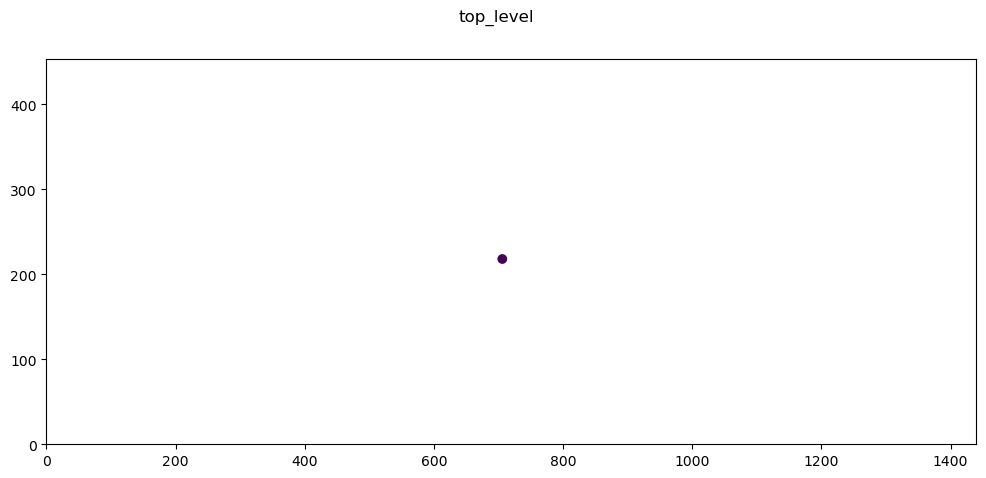

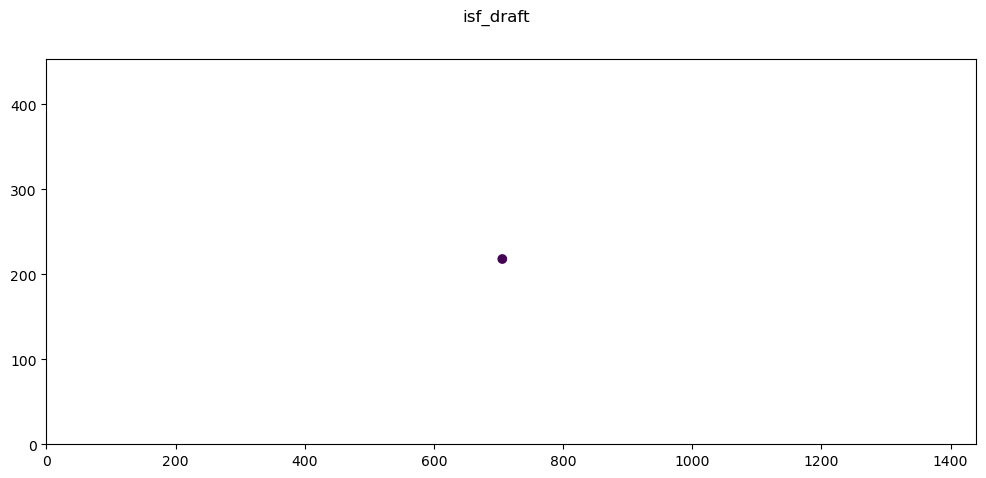

In [61]:
for var in var_uneq:
    if len(new_domcfg[var].dims) == 3:
        fig,ax = plot_change(new_domcfg.x, new_domcfg.y, (new_domcfg[var] - old_domcfg[var]).sum(dim='nav_lev'))
    else:
        fig,ax = plot_change(new_domcfg.x, new_domcfg.y, (new_domcfg[var] - old_domcfg[var]))

    fig.suptitle(var)